In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [0]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

# **Importing packages for all models**

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import time

In [0]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 60
num_classes = 10
batch_size = 100
learning_rate = 0.001

# **Load MNIST Dataset**

In [0]:
def data_loader():
  # MNIST dataset
  train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)

  test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

  # Data loader
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=batch_size, 
                                             shuffle=True)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size, 
                                            shuffle=False)
  return train_dataset, test_dataset, train_loader, test_loader


# *Function to plot many figures at once*

In [0]:
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

# **Fully Connected with 2 hidden layers**

In [0]:
train_dataset, test_dataset, train_loader, test_loader = data_loader()

Number of neurons per hidden layers can be adjusted below

In [0]:
import torch.nn.functional as F
input_size = 784
hidden_size_1 = 250
hidden_size_2 = 250
num_classes = 10

In [0]:
# Fully connected neural network with two hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, num_classes)  
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)


In [0]:
model = NeuralNet(input_size, hidden_size_1,hidden_size_2, num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [0]:
# Train the model
train_acc_arr= []
train_loss_arr = []
test_acc_arr = []
test_loss_arr = []
duration = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    t_start = time.time()
    output_compiled= []
    true_compiled = []
    loss_compiled = []
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        true_compiled.extend(labels.to(device))


        # Forward pass
        outputs = model(images)
        train_loss = criterion(outputs, labels)
        loss_compiled.append(train_loss.data.data.item())

        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Compute Accuracy
        _,argmax = torch.max(outputs,1)
        output_compiled.extend(argmax.squeeze())

        
    t_duration = time.time()- t_start
    train_acc = (np.array(true_compiled) == np.array(output_compiled)).mean()
    train_loss = np.array(loss_compiled).mean()
    train_acc_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    duration.append(t_duration)
    print('Epoch [{}/{}], Loss: {:.3f}, Accuracy: {:.3f}, Duration: {:.2f}'  
        .format(epoch+1, num_epochs, train_loss, train_acc, t_duration))

    test_output_compiled = []
    test_true_compiled = []
    test_loss_compiled = []

    for j, (test_images, test_labels) in enumerate(test_loader):
        test_images = test_images.reshape(-1,28*28).to(device)
        test_true_compiled.extend(test_labels.to(device))

        # Forward pass
        test_outputs = model(test_images)
        test_loss = criterion(test_outputs, test_labels)
        test_loss_compiled.append(test_loss.data.data.item())

        # Compute accuracy
        _, argmax = torch.max(test_outputs, 1)
        test_output_compiled.extend(argmax.squeeze())

    test_acc = (np.array(test_true_compiled) == np.array(test_output_compiled)).mean()
    test_acc_arr.append(test_acc)
    test_loss_arr.append(np.array(test_loss_compiled).mean())
print(sum(duration)/float(len(duration)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch [1/60], Loss: 0.582, Accuracy: 0.835, Duration: 7.38
Epoch [2/60], Loss: 0.208, Accuracy: 0.938, Duration: 7.59
Epoch [3/60], Loss: 0.150, Accuracy: 0.955, Duration: 7.07
Epoch [4/60], Loss: 0.114, Accuracy: 0.967, Duration: 6.92
Epoch [5/60], Loss: 0.090, Accuracy: 0.973, Duration: 6.72
Epoch [6/60], Loss: 0.074, Accuracy: 0.978, Duration: 6.85
Epoch [7/60], Loss: 0.059, Accuracy: 0.982, Duration: 6.72
Epoch [8/60], Loss: 0.048, Accuracy: 0.985, Duration: 6.77
Epoch [9/60], Loss: 0.039, Accuracy: 0.989, Duration: 6.79
Epoch [10/60], Loss: 0.032, Accuracy: 0.991, Duration: 6.71
Epoch [11/60], Loss: 0.026, Accuracy: 0.993, Duration: 6.77
Epoch [12/60], Loss: 0.021, Accuracy: 0.994, Duration: 6.81
Epoch [13/60], Loss: 0.017, Accuracy: 0.995, Duration: 6.83
Epoch [14/60], Loss: 0.013, Accuracy: 0.997, Duration: 6.81
Epoch [15/60], Loss: 0.011, Accuracy: 0.997, Duration: 6.72
Epoch [16/60], Loss: 0.008, Accuracy: 0.998, Duration: 6.84
Epoch [17/60], Loss: 0.007, Accuracy: 0.999, Dura

In [0]:
with torch.no_grad():
      correct = 0
      total = 0
      all_right_images = []
      all_wrong_images = []
      all_right_labels = []
      all_wrong_labels = []
      all_right_predicted = []
      all_wrong_predicted = []

      for images, labels in test_loader:
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          for i in range(len(predicted)):
              image_reshape = images[i].reshape(28,28)
              if predicted[i] != labels[i]:
                  all_wrong_images.append(image_reshape)
                  all_wrong_labels.append(labels[i].data.item())
                  all_wrong_predicted.append(predicted[i].data.item())
              elif predicted[i] == labels[i]:
                  all_right_images.append(image_reshape)
                  all_right_labels.append(labels[i].data.item())
                  all_right_predicted.append(predicted[i].data.item())

      print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Accuracy of the network on the 10000 test images: 97.85 %


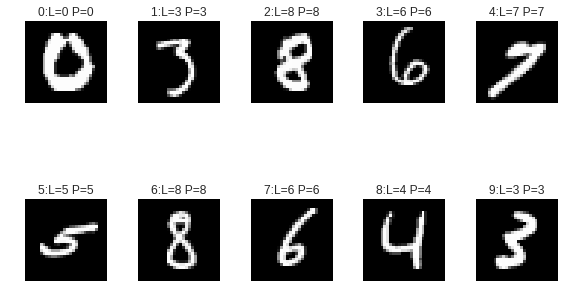

In [0]:
# Plot the some correct images
import random
number_of_im = 10
right_figures = {}
right_index = random.sample(range(0,len(all_right_images)-1),number_of_im)
ID = 0
for i in right_index:
    #index = np.random.randint(0,len(all_right_images)-1)
    #print(index)
    right_figures[str(ID) + ":" + "L=" + str(all_right_labels[i]) + " P=" + str(all_right_predicted[i])] = all_right_images[i]
    ID +=1
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(right_figures, 2, 5)

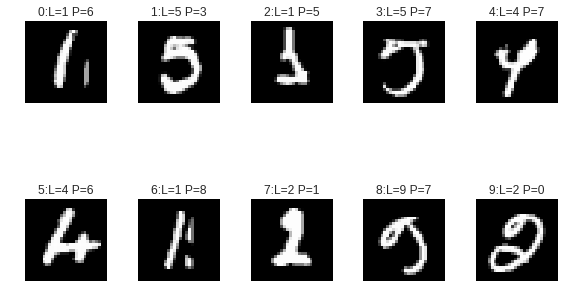

In [0]:
# Plot the some wrong images
number_of_im = 10
wrong_figures = {}
wrong_index = random.sample(range(0,len(all_wrong_images)-1),number_of_im)
ID = 0
for i in wrong_index:
    wrong_figures[str(ID) + ":" + "L=" + str(all_wrong_labels[i]) + " P=" + str(all_wrong_predicted[i])] = all_wrong_images[i]
    ID +=1
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(wrong_figures, 2, 5)

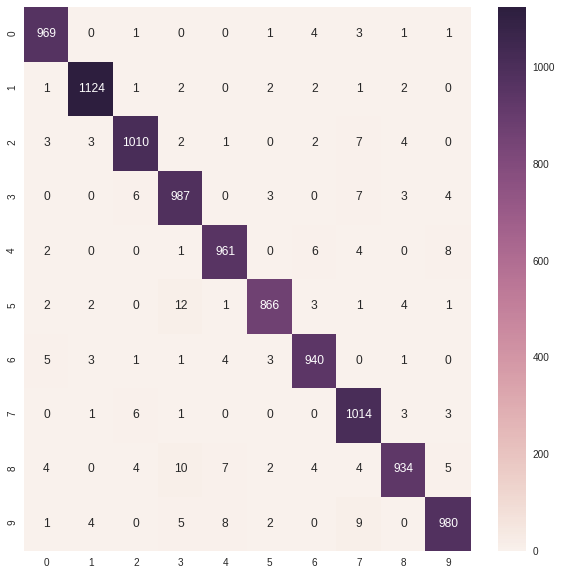

In [0]:
# Heat map for FC two hidden layers
all_labels = all_right_labels + all_wrong_labels
all_predicted = all_right_predicted + all_wrong_predicted

mat = confusion_matrix(all_labels, all_predicted)

label_predict = pd.DataFrame(mat, range(10),range(10))
# sn.set(font_scale=1.2) #for label size
plt.figure(figsize=(10, 10))
sn.heatmap(label_predict, annot=True,fmt='g')

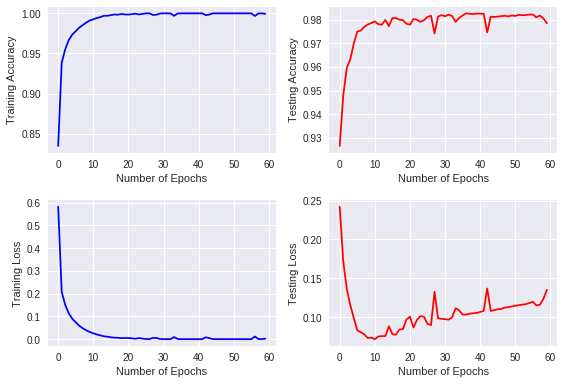

In [0]:
#PLotting accuracy and loss
plt.subplot(2,2,1)
plt.plot(train_acc_arr, 'b')
#plt.set_title("Accuracy plot")
plt.ylabel("Training Accuracy")
plt.xlabel("Number of Epochs")

plt.subplot(2,2,2)
plt.plot(test_acc_arr, 'r')
#plt.set_title("Accuracy plot")
plt.ylabel("Testing Accuracy")
plt.xlabel("Number of Epochs")

plt.subplot(2,2,3)
plt.plot(train_loss_arr, 'b')
#plt.set_title("Accuracy plot")
plt.ylabel("Training Loss")
plt.xlabel("Number of Epochs")

plt.subplot(2,2,4)
plt.plot(test_loss_arr, 'r')
#plt.set_title("Loss Plot")
plt.ylabel("Testing Loss")
plt.xlabel("Number of Epochs")

plt.tight_layout()
plt.show()

In [0]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')